https://www.dataquest.io/blog/jupyter-notebook-tips-tricks-shortcuts/

# Potential Plot
Minimization of the following:

$$\bar{u}_\text{pot} = \frac{U}{E_J} = -\big[ \alpha\cos(\varphi_{02}) + \cos(\varphi_{03}) + \cos(\varphi_{01}) + \\
+ \cos(\varphi_{02} - \varphi_{01} - L) + \cos(\varphi_{02} - \varphi_{03} + R)\big]
$$

In [1]:
from utils.array_stacker import ArrayStacker
from kernels.potential_minimum_searcher import PotentialMinimumSearcher
from kernels.potential_evaluator import PotentialEvaluator
from functions.potential import potential_function_cuda
from common import plotter
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from numba.cuda.cudadrv.devicearray import DeviceNDArray
from numba import cuda
import numpy as np
import math
import itertools
from collections import defaultdict
from typing import Tuple, List, Dict
from utils.info import allocate_max_threads, verify_blocks_per_grid


pi = math.pi
sin = np.sin
cos = np.cos

plt.style.use('my_official')

# Parameters of the simulation

In [2]:
NUMBER_OF_PHI_POINTS = 100
NUMBER_OF_FIELD_POINTS = 100
NUMBER_OF_FIELD_POINTS_PER_RUN = 20
NUMBER_OF_FIELD_RUNS = (
    NUMBER_OF_FIELD_POINTS - 1
) // NUMBER_OF_FIELD_POINTS_PER_RUN + 1
ALPHA = 1
LOWER = -0.5
UPPER = 1.5

lr_array = np.linspace(LOWER * 2 * pi, UPPER * 2 * pi, NUMBER_OF_FIELD_POINTS)
phixx_array = np.linspace(-pi, pi, NUMBER_OF_PHI_POINTS)

# Create kernels to cuda

In [3]:
BLOCKS_PER_GRID = (NUMBER_OF_FIELD_POINTS_PER_RUN, NUMBER_OF_FIELD_POINTS_PER_RUN)

potential_evaluator = PotentialEvaluator(NUMBER_OF_PHI_POINTS, potential_function_cuda)
THREADS_PER_BLOCK_potential_evaluation = allocate_max_threads(8)

potential_minimum_searcher = PotentialMinimumSearcher(NUMBER_OF_PHI_POINTS)
THREADS_PER_BLOCK_potential_search = allocate_max_threads()

🐳 Allocating           THREADS_PER_BLOCK = (8, 8, 8)
🐳 Allocating           THREADS_PER_BLOCK = (10, 10, 10)


# Execution

## Allocate arrays on GPU

In [4]:
DEVICE_lr_array = cuda.to_device(lr_array)
DEVICE_phixx_array = cuda.to_device(phixx_array)
DEVICE_potential_array = cuda.device_array(
    shape=(
        NUMBER_OF_FIELD_POINTS_PER_RUN,
        NUMBER_OF_FIELD_POINTS_PER_RUN,
        NUMBER_OF_PHI_POINTS,
        NUMBER_OF_PHI_POINTS,
        NUMBER_OF_PHI_POINTS,
    ),
    dtype=np.float64,
)
DEVICE_grid_search_result_array = cuda.device_array(
    shape=(NUMBER_OF_FIELD_POINTS_PER_RUN, NUMBER_OF_FIELD_POINTS_PER_RUN, 4),
    dtype=np.float32,
)

## Run kernels on each quadrant

In [5]:
# Go through teach of the field section and evaluate ##########################
quadrants = defaultdict(lambda: [[None] * NUMBER_OF_FIELD_RUNS for i in range(0, NUMBER_OF_FIELD_RUNS)])
for (L_RUN, R_RUN) in itertools.product(
    range(0, NUMBER_OF_FIELD_RUNS), range(0, NUMBER_OF_FIELD_RUNS)
):
    L_OFFSET = int(L_RUN * NUMBER_OF_FIELD_POINTS_PER_RUN)
    R_OFFSET = int(R_RUN * NUMBER_OF_FIELD_POINTS_PER_RUN)
    print(
        f"🦑 Running (L={L_RUN}/{NUMBER_OF_FIELD_RUNS - 1}, L_offset={L_OFFSET}), (R={R_RUN}/{NUMBER_OF_FIELD_RUNS - 1}, R_offset={R_OFFSET})"
    )
    potential_evaluator.kernel[BLOCKS_PER_GRID, THREADS_PER_BLOCK_potential_evaluation](
        DEVICE_phixx_array,
        DEVICE_lr_array,
        L_OFFSET,
        R_OFFSET,
        ALPHA,
        DEVICE_potential_array,
    )
    
    potential_minimum_searcher.kernel[
        BLOCKS_PER_GRID, THREADS_PER_BLOCK_potential_search
    ](DEVICE_potential_array, DEVICE_grid_search_result_array)
        
    grid_search_result_array = DEVICE_grid_search_result_array.copy_to_host()
    
    quadrants["potential"][L_RUN][R_RUN] = grid_search_result_array[:,:,0]
    quadrants["phi01"][L_RUN][R_RUN] = phixx_array[grid_search_result_array[:,:,1].astype(int)]
    quadrants["phi02"][L_RUN][R_RUN] = phixx_array[grid_search_result_array[:,:,2].astype(int)]
    quadrants["phi03"][L_RUN][R_RUN] = phixx_array[grid_search_result_array[:,:,3].astype(int)]

🦑 Running (L=0/4, L_offset=0), (R=0/4, R_offset=0)
🦑 Running (L=0/4, L_offset=0), (R=1/4, R_offset=20)
🦑 Running (L=0/4, L_offset=0), (R=2/4, R_offset=40)
🦑 Running (L=0/4, L_offset=0), (R=3/4, R_offset=60)
🦑 Running (L=0/4, L_offset=0), (R=4/4, R_offset=80)
🦑 Running (L=1/4, L_offset=20), (R=0/4, R_offset=0)
🦑 Running (L=1/4, L_offset=20), (R=1/4, R_offset=20)
🦑 Running (L=1/4, L_offset=20), (R=2/4, R_offset=40)
🦑 Running (L=1/4, L_offset=20), (R=3/4, R_offset=60)
🦑 Running (L=1/4, L_offset=20), (R=4/4, R_offset=80)
🦑 Running (L=2/4, L_offset=40), (R=0/4, R_offset=0)
🦑 Running (L=2/4, L_offset=40), (R=1/4, R_offset=20)
🦑 Running (L=2/4, L_offset=40), (R=2/4, R_offset=40)
🦑 Running (L=2/4, L_offset=40), (R=3/4, R_offset=60)
🦑 Running (L=2/4, L_offset=40), (R=4/4, R_offset=80)
🦑 Running (L=3/4, L_offset=60), (R=0/4, R_offset=0)
🦑 Running (L=3/4, L_offset=60), (R=1/4, R_offset=20)
🦑 Running (L=3/4, L_offset=60), (R=2/4, R_offset=40)
🦑 Running (L=3/4, L_offset=60), (R=3/4, R_offset=60)
🦑 

## Collect up results

In [6]:
result = {key: ArrayStacker.stack_into_square(value)
          for key, value in quadrants.items()}

for key in ["phi01", "phi02", "phi03"]:
    result[key] = result[key] / (2 * pi)

# Analysis
For cells {0,0} {0,1} and {1,0}, the degeneracy point it is located at
\begin{equation}
    \varphi_T = 2\arccos \left( \sqrt{\alpha^2 + 1} - \alpha \right)
\end{equation}

## Plot minimal values

<IPython.core.display.Javascript object>


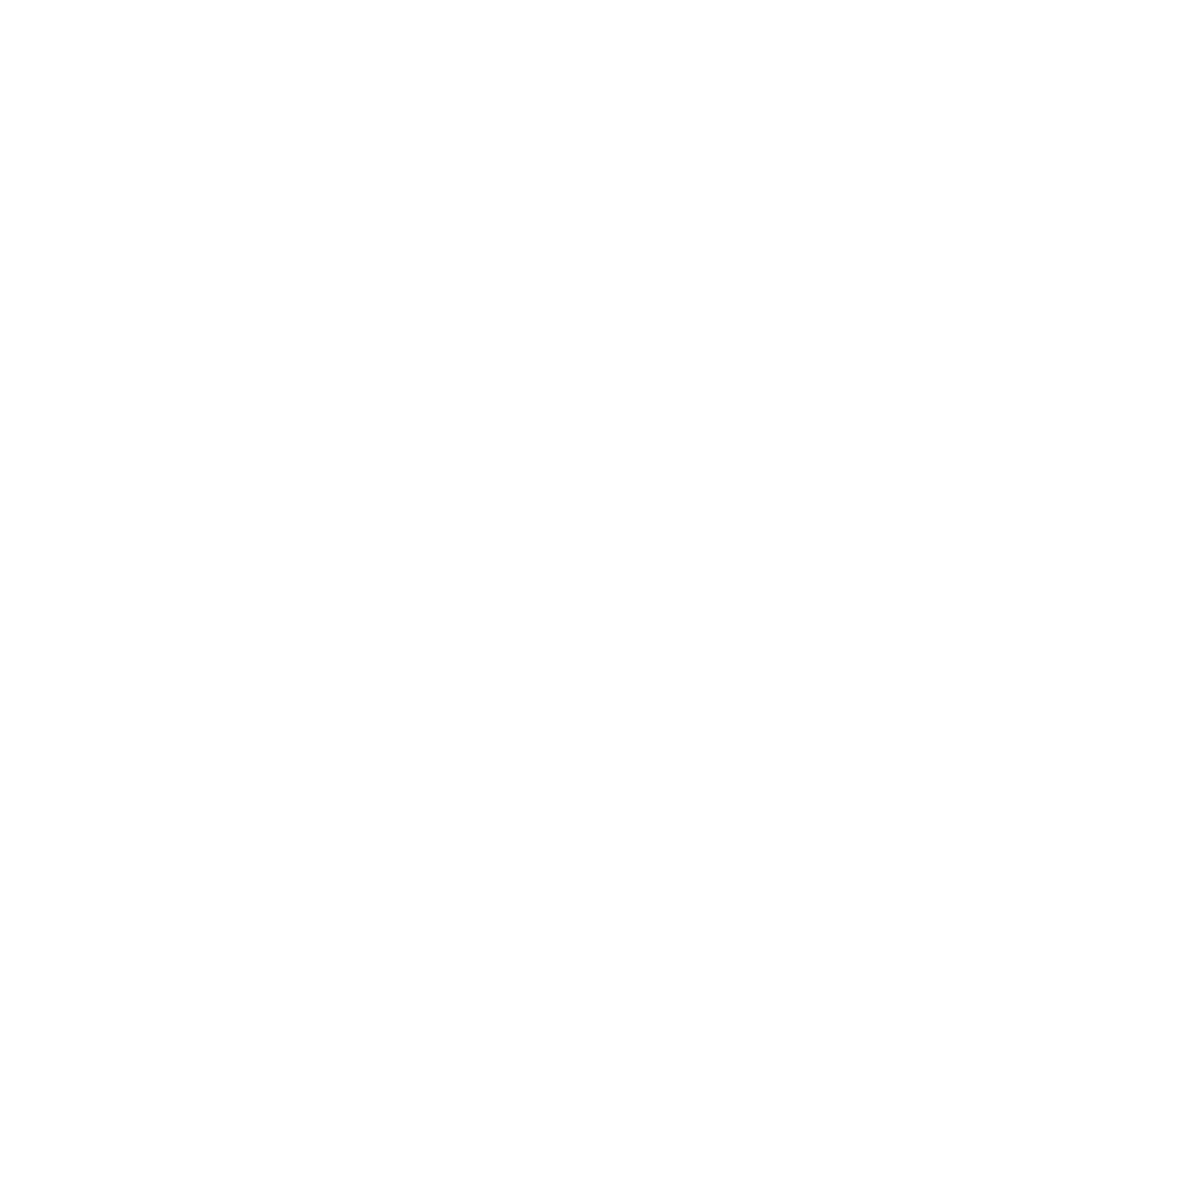

Text(0.5, 0, '$\\varphi_l/2\\pi$')

In [7]:
%matplotlib notebook
fig, ax = plt.subplots(2, 2, sharex=True, sharey=True, figsize=(6, 6))
plt.subplots_adjust(left=0.1, bottom=None, right=0.85,
                    top=None, wspace=None, hspace=None)
cb = defaultdict(lambda: defaultdict(int))
im = defaultdict(lambda: defaultdict(int))

im[0][0] = ax[0][0].imshow(result["potential"],
                           extent=[LOWER, UPPER, LOWER, UPPER],
                           origin='lower',
                           interpolation='bessel',
                           vmin=0, vmax=2.2)
ax[0][0].set_title(r"$U_{min}/E_J$", fontsize=14, loc="left")

im[0][1] = ax[0][1].imshow(result["phi02"],
                           extent=[LOWER, UPPER, LOWER, UPPER],
                           origin='lower',
                           cmap='RdGy',
                           interpolation='bessel',
                           vmin=-0.5, vmax=0.5)
ax[0][1].set_title(r"$\varphi_{02}$", fontsize=14)

im[1][0] = ax[1][0].imshow(result["phi01"] + result["phi01"],
                           extent=[LOWER, UPPER, LOWER, UPPER],
                           origin='lower',
                           cmap='RdGy',
                           interpolation='bessel',
                           vmin=-0.5, vmax=0.5)
ax[1][0].set_title(r"$\varphi_{01} + \varphi_{12}$", fontsize=14)

im[1][1] = ax[1][1].imshow(result["phi03"] + result["phi03"],
                           extent=[LOWER, UPPER, LOWER, UPPER],
                           origin='lower',
                           cmap='RdGy',
                           interpolation='bessel',
                           vmin=-0.5, vmax=0.5)
ax[1][1].set_title(r"$\varphi_{03} + \varphi_{32}$", fontsize=14)

# Colorbars
for (i, j) in list(itertools.product([0, 1], [0, 1])):
    if i == 0 and j == 0:
        cb[i][j] = fig.colorbar(im[i][j], ax=ax[i][j],
                                fraction=0.046, pad=0.04)
        cb[i][j].ax.set_ylabel(
            r"$\frac{U_{min}}{E_J}$", fontsize=8, rotation=0, ha="left", labelpad=-25, y=1.15)
        cb[i][j].set_ticks([0, 0.5, 1, 1.5, 2])
    else:
        cb[i][j] = fig.colorbar(im[i][j], ax=ax[i][j],
                                fraction=0.046, pad=0.04)
        cb[i][j].ax.set_ylabel(
            r"$\frac{\varphi}{2\pi}$", fontsize=8, rotation=0, ha="left", labelpad=-32, y=1.11)
        cb[i][j].set_ticks([-0.5, 0, 0.5])
    cb[i][j].ax.tick_params(labelsize=8)
    
# Degeneracy
phiT0 = 2 * math.acos(math.sqrt(float(ALPHA ** 2 + 1)) - ALPHA) / (2 *  math.pi)
phiT1 = (2 * pi - 2 * math.acos(math.sqrt(float(ALPHA ** 2 + 1)) - ALPHA)) / (2 *  math.pi)
ax[0][0].scatter(float(phiT0), float(phiT0), marker='x', color='red', s=20)
ax[0][0].scatter(float(phiT1), float(phiT1), marker='x', color='red', s=20)
ax[0][0].scatter(float(0.5), float(0.5), marker='x', color='C2', s=20)

# X ticks
ax[0][0].set_xticks([-0.5, 0, 0.5, 1, 1.5])
# Axes Labels
ax[0][0].set_ylabel(r"$\varphi_r/2\pi$", fontsize=14)
ax[1][0].set_xlabel(r"$\varphi_l/2\pi$", fontsize=14)
ax[1][0].set_ylabel(r"$\varphi_r/2\pi$", fontsize=14)
ax[1][1].set_xlabel(r"$\varphi_l/2\pi$", fontsize=14)

In [8]:
plotter.save_onto_white_background(ax, "./output/potential_minimum_diamonds", "pdf")

## 3D Plot of potential

<IPython.core.display.Javascript object>


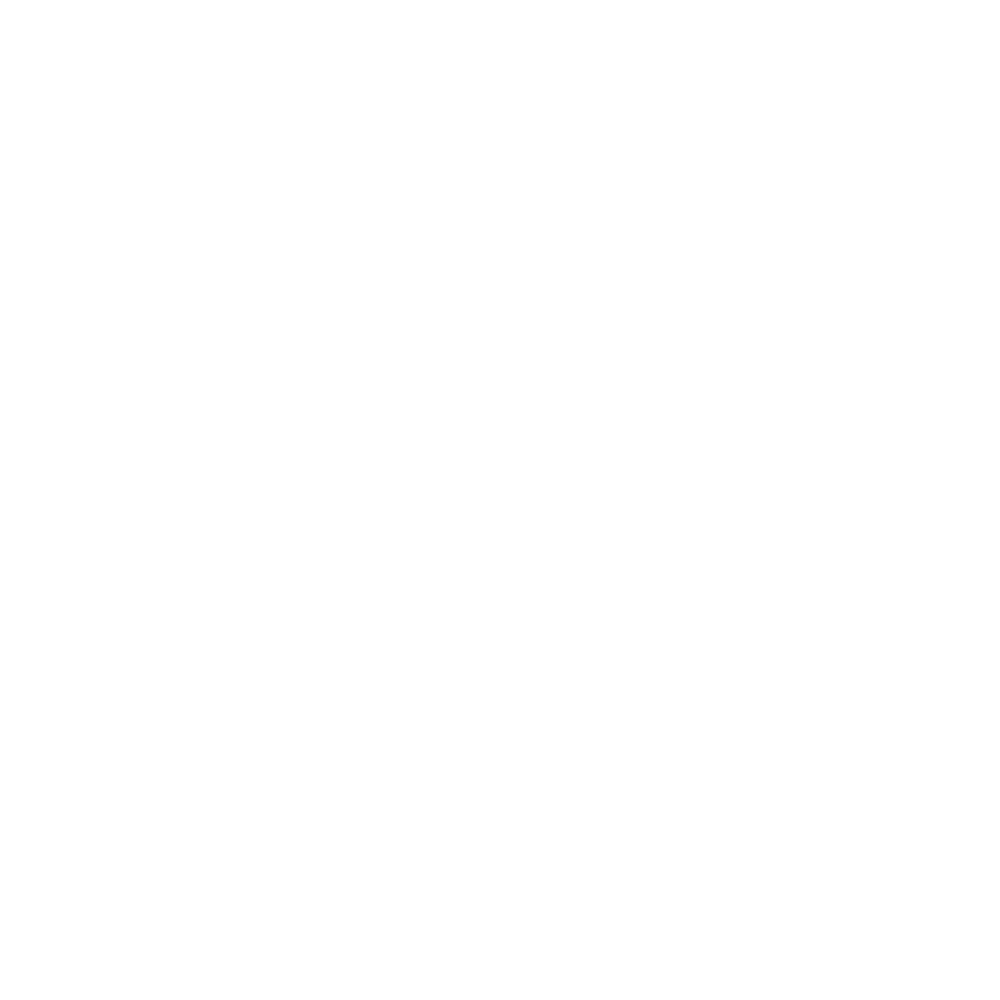

In [9]:
%matplotlib notebook

fig = plt.figure(figsize=(5,5))
ax = fig.gca(projection='3d')

grid_x, grid_y = np.meshgrid(lr_array, lr_array)
surf = ax.plot_surface(grid_x, grid_y, 
                       result["phi02"], 
                       #quadrants["potential"][0][0],
                       cmap=cm.coolwarm,
                       linewidth=0, antialiased=True)
fig.colorbar(surf, shrink=0.5, aspect=10)

## Parabollic approximation comparisson
- Along $\varphi_l == \varphi_r$
- Along $\frac{\varphi_l + \varphi_r}{2} = \pi \equiv \varphi_+$ 

### Naive approximation
Just immediately expand the cosines, no thinking about if it is valid
$$\varphi_{02} \approx \frac{\varphi_l-\varphi_r - 2\pi(L-R)}{2(1+\alpha)}$$
$$\frac{U_\text{min}}{E_J}   \approx \left(\frac{\varphi_{02}   - \varphi_l + 2\pi L}{2}\right)^2 + \left(\frac{\varphi_{02} +  \varphi_r - 2\pi R}{2}\right)^2 + \frac{\alpha}{2}\varphi_{02}^2$$

In [10]:
def phi02_naive_approximation(phi_l: float, phi_r: float, L: int, R: int, alpha: float):
    return (phi_l - phi_r - 2 * pi * (L - R)) / (2 * (1 + alpha))


def potential_naive_approximation(phi02: float, phi_l: float, phi_r: float, L: int, R: int, alpha: float):
    
    #return ((phi02 - phi_l + 2 * pi * L)**2) / 4 + ((phi02 + phi_r - 2 * pi * R) ** 2 / 4) + alpha * phi02 # (alpha * phi02 ** 2) / 2
    
    return (phi02 - phi_l + 2 * pi * L) ** 2 / 4 + (phi02 + phi_r - 2 * pi * R) ** 2 / 4 + alpha * phi02 ** 2 / 2

In [11]:
potential_slice_naive = defaultdict(list)
alpha = 1

for phi_l_idx, phi_l in enumerate(lr_array):
    phi_r_idx = len(lr_array) - phi_l_idx - 1
    phi_r = lr_array[phi_r_idx]

    potential_slice_naive["potential_phi_plus"].append(
        result["potential"][phi_l_idx][phi_r_idx]
    )

    min_potential = None
    for (L, R) in itertools.permutations([-1, 0, 1], r=2):
        phi02 = phi02_naive_approximation(phi_l, phi_r, L, R, alpha)
        potential = potential_naive_approximation(
            phi02, phi_l, phi_r, L, R, alpha)

        if min_potential is None or potential < min_potential:
            min_potential = potential
        if L == 0 and R == 1:
            potential_slice_naive["potential_phi_approximation_01"].append(potential)
        if L == 1 and R == 0:
            potential_slice_naive["potential_phi_approximation_10"].append(potential)

    potential_slice_naive["potential_phi_approximation"].append(min_potential)

<IPython.core.display.Javascript object>


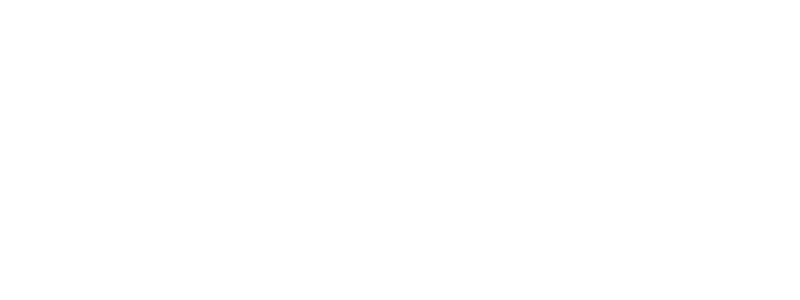

In [12]:
%matplotlib notebook
fig, ax = plt.subplots(1, 1, figsize=(4, 1.5))
plt.subplots_adjust(left=None, bottom=0.2, right=None, top=None, wspace=1, hspace=None)

ax.plot(potential_slice_naive["potential_phi_plus"])
ax.plot(potential_slice_naive["potential_phi_approximation_01"], color='red')
ax.plot(potential_slice_naive["potential_phi_approximation_10"], color='red')
ax.plot(potential_slice_naive["potential_phi_approximation"], color='yellow')


# X ticks
ax.set_xticks(list(np.linspace(0, NUMBER_OF_FIELD_POINTS, 5)))
ax.set_ylim([0, 3])
ax.set_xticklabels([-0.5, 0, 0.5, 1, 1.5])
None

### Thorough approximation with $\delta$ from the center
$$\frac{U_\text{min}}{E_J}   \approx\left(\frac{\varphi_{02} - \delta_l}{2}\right)^2 +  \left(\frac{\varphi_{02}+ \delta_r}{2}\right)^2 +
        \frac{\alpha}{2}\varphi_{02}^2$$
        
where we have deviations 
- $\delta_l=\varphi_l-2\pi    L$
- $\delta_r=\varphi_r-2\pi R$ 
- $\varphi_{02}   \approx  \frac{\delta_{l}   -  \delta_r}{2(1+\alpha)}$

from the center of cell $\{L,R\}$.

In [13]:
def potential_approximation(phi_l: float, phi_r: float, L: int, R: int, alpha: float):
    delta_l = phi_l - 2 * pi * L
    delta_r = phi_r - 2 * pi * R
    phi02 = (delta_l - delta_r) / (2 * (1 + alpha))

    #return ((phi_02 - delta_l) ** 2) / 4 + ((phi_02 + delta_r) ** 2) / 4 + alpha * phi02 #(alpha * phi02 ** 2) / 2
    
    return (phi02 - delta_l) ** 2 / 4 + (phi02 + delta_r) ** 2 / 4 + alpha * phi02 ** 2 / 2

In [14]:
potential_slice = defaultdict(list)
alpha = 1

for phi_l_idx, phi_l in enumerate(lr_array):
    phi_r_idx = len(lr_array) - phi_l_idx - 1
    phi_r = lr_array[phi_r_idx]

    potential_slice["potential_phi_plus"].append(
        result["potential"][phi_l_idx][phi_r_idx]
    )

    min_potential = None
    for (L, R) in itertools.permutations([-1, 0, 1], r=2):
        potential = potential_approximation(phi_l, phi_r, L, R, alpha)
        phi02 = phi02_naive_approximation(phi_l, phi_r, L, R, alpha)
        potential_naive = potential_naive_approximation(phi02, phi_l, phi_r, L, R, alpha)
        assert abs(potential - potential_naive) < 0.00000001, f"{potential}--{potential_naive}"

        if min_potential is None or potential < min_potential:
            min_potential = potential
        if L == 0 and R == 1:
            potential_slice["potential_phi_approximation_01"].append(potential)
        if L == 1 and R == 0:
            potential_slice["potential_phi_approximation_10"].append(potential)

    potential_slice["potential_phi_approximation"].append(min_potential)
print("done")

done


<IPython.core.display.Javascript object>


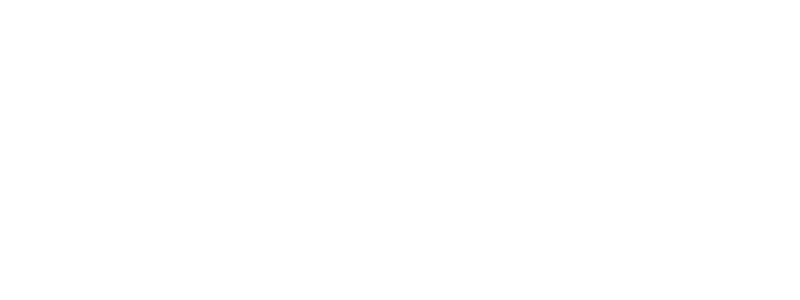

[Text(0, 0, '-0.5'),
 Text(0, 0, '0'),
 Text(0, 0, '0.5'),
 Text(0, 0, '1'),
 Text(0, 0, '1.5')]

In [15]:
%matplotlib notebook
fig, ax = plt.subplots(1, 1, figsize=(4, 1.5))
plt.subplots_adjust(left=None, bottom=0.2, right=None, top=None, wspace=1, hspace=None)

ax.plot(potential_slice["potential_phi_plus"])
ax.plot(potential_slice["potential_phi_approximation_01"], color='red')
ax.plot(potential_slice["potential_phi_approximation_10"], color='red')
ax.plot(potential_slice["potential_phi_approximation"], color='yellow')

# X ticks
ax.set_xticks(np.linspace(0, NUMBER_OF_FIELD_POINTS, 5))
ax.set_ylim([0, 3])
ax.set_xticklabels([-0.5, 0, 0.5, 1, 1.5])

# 2D Plot of potential
Investigate region around the degenreacy point

## Parameters

In [27]:
from kernels.potential_evaluated_in_phi02_phi01_plane import PotentialEvaluatedInPhi02Phi02Plane

NUMBER_OF_PHI_POINTS_FOR_2D = 100
ALPHA_2D_plot = [0.8, 1, 1.2]
phi01_bounds = (-0.5, 0.5)
phi02_bounds = (0, 1)

phi01_array = np.linspace(2 * pi * phi01_bounds[0],
                          2 * pi * phi01_bounds[1], NUMBER_OF_PHI_POINTS_FOR_2D)
phi02_array = np.linspace(2 * pi * phi02_bounds[0],
                          2 * pi * phi02_bounds[1], NUMBER_OF_PHI_POINTS_FOR_2D)
phi03_array = np.linspace(2 * pi * phi01_bounds[0],
                          2 * pi * phi01_bounds[1], NUMBER_OF_PHI_POINTS_FOR_2D)

## Kernel creation

In [28]:
BLOCKS_PER_GRID_FOR_2D = (NUMBER_OF_PHI_POINTS_FOR_2D, NUMBER_OF_PHI_POINTS_FOR_2D)
verify_blocks_per_grid(BLOCKS_PER_GRID_FOR_2D)
THREADS_PER_BLOCK_FOR_2D = allocate_max_threads()

potential_evaluated_in_phi02_phi01_plane = PotentialEvaluatedInPhi02Phi02Plane(NUMBER_OF_PHI_POINTS_FOR_2D, potential_function_cuda)

🐳 Verified             BLOCKS_PER_GRID=(100, 100)
🐳 Allocating           THREADS_PER_BLOCK = (10, 10, 10)


## Array allocation on GPU

In [29]:
DEVICE_phi01_array = cuda.to_device(phi01_array)
DEVICE_phi02_array = cuda.to_device(phi02_array)
DEVICE_phi03_array = cuda.to_device(phi03_array)

DEVICE_output_2d_plot = cuda.device_array(
    shape=(NUMBER_OF_PHI_POINTS_FOR_2D, NUMBER_OF_PHI_POINTS_FOR_2D),
    dtype=np.float64,
)

## Running

In [30]:
output_2d_plot = {}
for alpha in ALPHA_2D_plot:
    potential_evaluated_in_phi02_phi01_plane.kernel[BLOCKS_PER_GRID_FOR_2D, THREADS_PER_BLOCK_FOR_2D](
        DEVICE_phi01_array,
        DEVICE_phi02_array,
        DEVICE_phi03_array,
        pi,
        pi,
        alpha,
        DEVICE_output_2d_plot,
    )
    output_2d_plot[f"{alpha}"] = (DEVICE_output_2d_plot.copy_to_host())

## Post processing
Now minimise $U(\varphi_{01}, \varphi_{02})$ with respect to $\varphi_{01}$


### Warning
Remember! Matplotlib is retarded!
If you give it an array (100,20), it will plot:
- 100 points along the y axis  **(idx0=100 is for the y axis)** 100 rows
- 20 points along the x axis   **(idx1=20 is for the x axis)** 20 columns


Therefore for searching the minimal value at each x value, you need to search the top-level axis=1
### Because of this, a reflection will be needed for further x-y things plotted onto it

In [68]:
def reflect_in_line(x_array: List[float], y_array: List[float],
                        m: float, c: float) -> Tuple[List[float], List[float]]:
    """Takes arrays of x-y pairs and reflects them about
            y = mx + c
    shift -> reflection in line -> -shift
    """
    reflection_matrix = np.matrix([[1 - m**2, 2 * m],
                                   [2 * m, m**2 - 1]]) / (1 + m**2)

    x_list, y_list = [], []
    for (x, y) in zip(x_array, y_array):
        vec = np.array([x, y]) - np.array([0, c])
        vec = reflection_matrix.dot(vec)
        vec = vec.tolist()[0]
        vec = vec + np.array([0, c])
        x_list.append(vec[0])
        y_list.append(vec[1])
    return (np.array(x_list), np.array(y_list))

def reflect_in_line_points(x, y, m, c) -> Tuple[float, float]:
        (reflected_x, reflected_y) = reflect_in_line([x], [y], m, c)
        return (reflected_y[0], reflected_x[0])

In [32]:
plt.contourf(
    phi02_array / (2 * pi),
    phi01_array / (2 * pi),
    output_2d_plot["1"],
    levels=25,
    origin=None,
    vmin=2, vmax=6)

phi02_plot, phi01_plot = reflect_in_line(
    phi02_array / (2 * pi),
    phi01_array[np.argmin(
        output_2d_plot["1"], axis=1)] / (2 * pi),
    m=1,
    c=-0.5)

plt.scatter(phi02_plot, phi01_plot)
plt.show()

### Run the search

In [33]:
potential_minimised_wrt_phi01_phi03 = defaultdict(lambda: defaultdict(int))

for (key, potential_array) in output_2d_plot.items():
    min_indexes = np.argmin(potential_array, axis=1)    

    potential_minimised_wrt_phi01_phi03[key]["potential"] = np.min(potential_array, axis=0)
    
    (phi02_plot, phi01_plot) = reflect_in_line(
        phi02_array, phi01_array[min_indexes], m=1, c=-0.5 * (2 * pi))
    potential_minimised_wrt_phi01_phi03[key]["phi01_plot"] = phi01_plot
    potential_minimised_wrt_phi01_phi03[key]["phi02_plot"] = phi02_plot

## Plotting
**Note that in the array**
- phi02 runs along index=1
- phi01 runs along index=0

<IPython.core.display.Javascript object>


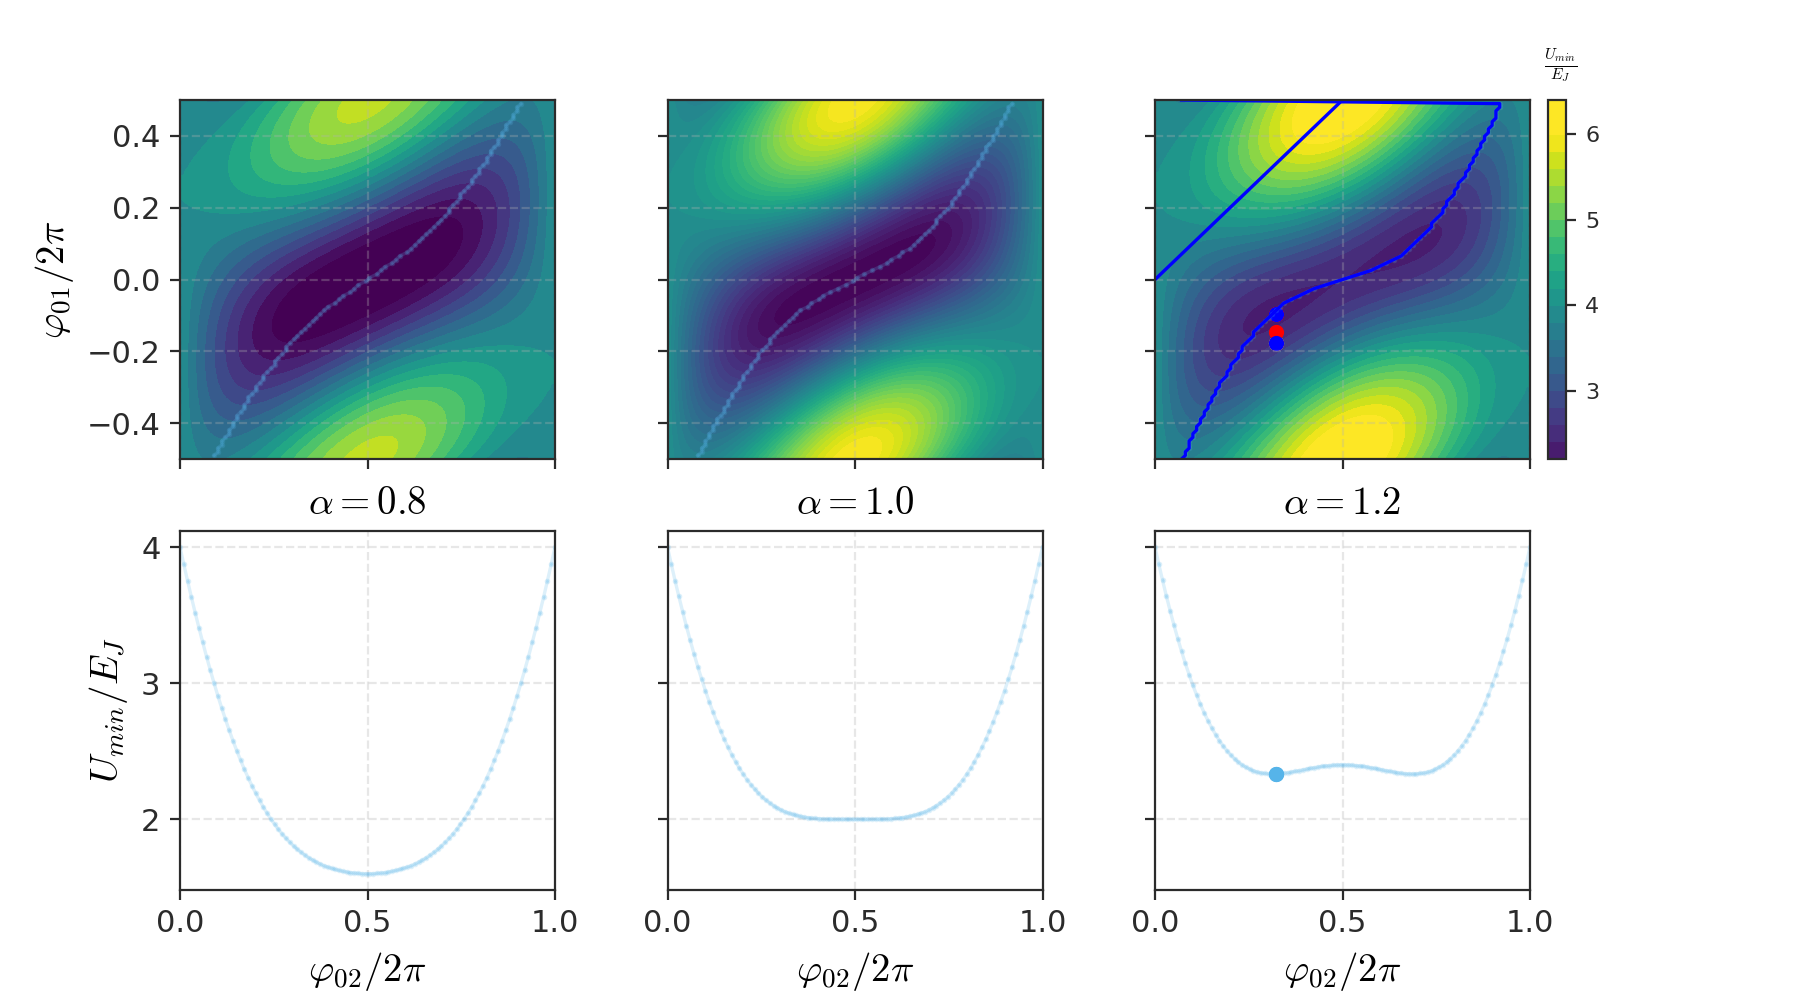

Text(0, 0.5, '$U_{min}/E_J$')

In [79]:
%matplotlib notebook

fig = plt.figure(figsize=(9,5))
ax = defaultdict(lambda: defaultdict(int))
ax[0][0] = fig.add_subplot(2,3,1)
ax[0][1] = fig.add_subplot(2,3,2, sharey=ax[0][0])
ax[0][2] = fig.add_subplot(2,3,3, sharey=ax[0][1])
ax[0][0].tick_params(labelbottom=False)
ax[0][1].tick_params(labelleft=False)
ax[0][1].tick_params(labelbottom=False)
ax[0][2].tick_params(labelleft=False)
ax[0][2].tick_params(labelbottom=False)
ax[1][0] = fig.add_subplot(2,3,4, sharex=ax[0][0])
ax[1][1] = fig.add_subplot(2,3,5, sharex=ax[0][1], sharey=ax[1][0])
ax[1][2] = fig.add_subplot(2,3,6, sharex=ax[0][2], sharey=ax[1][0])
ax[1][1].tick_params(labelleft=False)
ax[1][2].tick_params(labelleft=False)

plt.subplots_adjust(left=0.1, bottom=None, right=0.85,
                    top=None, wspace=None, hspace=None)
cb = defaultdict(lambda: defaultdict(int))
im = defaultdict(lambda: defaultdict(int))

im[0][0] = ax[0][0].contourf(phi02_array / (2 * pi), phi01_array /
                       (2 * pi), output_2d_plot["0.8"], levels=18,
                       origin='lower',
                       vmin=2, vmax=6)
ax[0][0].plot(
    potential_minimised_wrt_phi01_phi03["0.8"]["phi02_plot"][1:-1] / (2 * pi), 
    potential_minimised_wrt_phi01_phi03["0.8"]["phi01_plot"][1:-1] / (2 * pi),
    color='C2', marker='.', alpha=0.2
)
ax[1][0].set_title(r"$\alpha=0.8$", fontsize=14)
ax[1][0].plot(
    phi02_array / (2 * pi), 
    potential_minimised_wrt_phi01_phi03["0.8"]["potential"],
    color='C2', marker='.', alpha=0.2
)

im[0][1] = ax[0][1].contourf(phi02_array / (2 * pi), phi01_array /
                       (2 * pi), output_2d_plot["1"], levels=40,
                       origin='lower',
                       vmin=2, vmax=6)
ax[0][1].plot(
    potential_minimised_wrt_phi01_phi03["1"]["phi02_plot"][1:-1] / (2 * pi), 
    potential_minimised_wrt_phi01_phi03["1"]["phi01_plot"][1:-1] / (2 * pi),
    color='C2', marker='.', alpha=0.2
)
ax[1][1].set_title(r"$\alpha=1.0$", fontsize=14)
ax[1][1].plot(
    phi02_array / (2 * pi), 
    potential_minimised_wrt_phi01_phi03["1"]["potential"],
    color='C2', marker='.', alpha=0.2
)

im[0][2] = ax[0][2].contourf(phi02_array / (2 * pi), phi01_array /
                       (2 * pi), output_2d_plot["1.2"], levels=20,
                       origin='lower',
                       vmin=2, vmax=6)
ax[0][2].plot(
    potential_minimised_wrt_phi01_phi03["1.2"]["phi02_plot"][1:-1] / (2 * pi), 
    potential_minimised_wrt_phi01_phi03["1.2"]["phi01_plot"][1:-1] / (2 * pi),
    color='C2', marker='.', alpha=0.2
)
ax[1][2].set_title(r"$\alpha=1.2$", fontsize=14)
ax[1][2].plot(
    phi02_array / (2 * pi), 
    potential_minimised_wrt_phi01_phi03["1.2"]["potential"],
    color='C2', marker='.', alpha=0.2
)

#Magic for extra axes to put colorbar
(x0, y0, width, height) = ax[0][2].get_position().bounds
(w_pad, h_pad, wspace, hspace) = fig.get_constrained_layout_pads()
cb_axes = fig.add_axes([x0 + width + wspace / 2, y0, wspace, height])
cb_axes.set_visible(False)
cb = fig.colorbar(im[0][2], ax=cb_axes,
                 fraction=1
                 )
cb.ax.set_ylabel(
    r"$\frac{U_{min}}{E_J}$", fontsize=8, rotation=0, ha="left", labelpad=-20, y=1.15)
cb.ax.tick_params(labelsize=8)
cb.set_ticks([3, 4, 5, 6])

# Axes labels
for i in range(0, 3):
    ax[1][i].set_xticks([0, 0.5, 1.0])
    ax[1][i].set_xlabel(r"$\varphi_{02}/2\pi$", fontsize=14)
ax[0][0].set_ylabel(r"$\varphi_{01}/2\pi$", fontsize=14)
ax[1][0].set_ylabel(r"$U_{min}/E_J$", fontsize=14)

### Add the potential dips in double well
\begin{equation}
\varphi_{02}=\pi\pm2\arccos\frac{1}{\alpha}, \alpha > 1.
\end{equation}

In [96]:
ax[0][2].plot(potential_minimised_wrt_phi01_phi03["1.2"]["phi02_plot"]/ (2*pi), potential_minimised_wrt_phi01_phi03["1.2"]["phi01_plot"] / (2 * pi),color='blue')

In [85]:
def dip_evaluator() -> List[Dict]:
    "TODO: alpha=1.2 is hardcoded"
    dip_list = []
    for dip_phi02 in [np.pi - 2 * np.arccos(1/1.2),
                      np.pi + 2 * np.arccos(1/1.2)]:

        # Find the index to extract from other lists
        dip_idx = next(idx for (idx, phi02) in enumerate(
            phi02_array) if phi02 > dip_phi02)
        dip_idx_reflected = next(idx for (idx, phi02) in enumerate(
            potential_minimised_wrt_phi01_phi03["1.2"]["phi01_plot"][dip_idx]) if phi02 > dip_phi02)        

        dip_list.append({
            "phi02": dip_phi02,
            "phi02_reflected": potential_minimised_wrt_phi01_phi03["1.2"]["phi02_plot"][dip_idx_reflected],
            "phi01_reflected": potential_minimised_wrt_phi01_phi03["1.2"]["phi01_plot"][dip_idx_reflected],
            "potential": potential_minimised_wrt_phi01_phi03["1.2"]["potential"][dip_idx]
        })
    return dip_list

In [87]:
dip_list = dip_evaluator()

ax[0][2].scatter(dip_list[0]["phi02"] / (2*pi), dip_list[0]["phi01"] / (2 * pi),
                 marker='o', color='C2', s=20)
#ax[1][2].scatter(dip_list[0]["phi02"] / (2*pi), dip_list[0]["potential"],
#                 marker='o', color='C2', s=20)

32
68


In [26]:
dip_2 = np.pi + 2 * np.arccos(1/1.2)
dip_2_idx = next(idx for (idx, phi02) in enumerate(
    phi02_array) if phi02 > dip_2)
# dip2 = (phi02_array[dip_2_idx] / (2 * pi),
#         potential_minimised_wrt_phi01_phi03["1.2"]["potential"][dip_2_idx],
#         potential_minimised_wrt_phi01_phi03["1.2"]["phi02_plot"][dip_2_idx] / (2 * pi))
# ax[1][2].scatter(dip1[0], dip1[1],
#                  marker='o', color='C2', s=20)
# ax[1][2].scatter(dip2[0], dip2[1],
#                  marker='o', color='C2', s=20)